# Phishing Detection from HTML Content
This starter notebook shows how to train a machine‑learning model that classifies web pages as **phishing** or **benign** based on their raw HTML.

Feel free to adapt folder paths, feature engineering, and model choice to your dataset.

In [ ]:
# !pip install beautifulsoup4 lxml scikit-learn pandas numpy tqdm joblib

In [ ]:
import pathlib, re, json, joblib, random
from tqdm import tqdm
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import glob, pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd


In [ ]:
import pathlib

# === Path configuration ===
# ZIP עם אתרי phishing הועלה בשם /content/htmls.zip
ZIP_PATH   = pathlib.Path('/content/htmls.zip')

# יעד הפריסה
PHISH_DIR  = pathlib.Path('/content/htmls')      # שימי לב: /content/htmls

import subprocess, glob

# צרי את התיקייה אם חסרה
PHISH_DIR.mkdir(exist_ok=True)

# פרסי את ה-ZIP רק אם התיקייה עדיין ריקה
if not any(PHISH_DIR.iterdir()):
    if ZIP_PATH.exists():
        print("פורסת את", ZIP_PATH)
        subprocess.run(['unzip', '-q', str(ZIP_PATH), '-d', str(PHISH_DIR)], check=True)
    else:
        raise FileNotFoundError(f'{ZIP_PATH} לא נמצא – ודאי שהעלית zip נכון')

print("קבצי phishing שזוהו:", len(glob.glob(str(PHISH_DIR / '**/*.html'), recursive=True)))



קבצי phishing שזוהו: 43933


In [ ]:

import base64, io, re
from bs4 import BeautifulSoup

def b64_to_html(b64_str: str) -> str:
    """Decode base64 -> UTF‑8 HTML string."""

    try:
        return base64.b64decode(b64_str).decode('utf-8', errors='ignore')
    except Exception as e:
        print('שגיאת Base64:', e)
        return ''

def html_to_features(source):
    if isinstance(source, pathlib.Path):
        html = source.read_text(errors='ignore')
    elif hasattr(source, 'read'):
        html = source.read()
    else:
        html = str(source)

    soup = BeautifulSoup(html, 'lxml')

    # Extract and remove non-visible tags
    scripts = soup.find_all('script')
    styles = soup.find_all('style')
    for tag in (scripts + styles + soup.find_all('noscript')):
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True)

    # Structural stats
    all_tags = soup.find_all(True)  # any tag
    total_tags = len(all_tags)
    num_img_tags = len(soup.find_all('img'))
    num_script_tags = len(scripts)
    html_length = len(html)
    total_script_length = sum(len(script.get_text(strip=True)) for script in scripts)

    # Other relevant tags
    num_form_tags = len(soup.find_all('form'))
    num_input_tags = len(soup.find_all('input'))
    num_pw_inputs = len(soup.find_all('input', {'type': 'password'}))
    num_iframes = len(soup.find_all('iframe'))
    num_a_tags = len(soup.find_all('a'))
    num_button_tags = len(soup.find_all('button'))
    num_div_tags = len(soup.find_all('div'))
    num_span_tags = len(soup.find_all('span'))

    # Heuristic: page is essentially just one image
    is_single_image = int(num_img_tags == 1 and len(text.strip()) < 30)

    # External links
    num_external_links = sum(
        1 for a in soup.find_all('a', href=True)
        if re.match(r'^https?://', a['href'])
    )

    return {
        'text': text,
        'html_length': html_length,
        'total_tags': total_tags,
        'num_img_tags': num_img_tags,
        'num_script_tags': num_script_tags,
        'total_script_length': total_script_length,
        'num_form_tags': num_form_tags,
        'num_input_tags': num_input_tags,
        'num_pw_inputs': num_pw_inputs,
        'num_iframe_tags': num_iframes,
        'num_a_tags': num_a_tags,
        'num_button_tags': num_button_tags,
        'num_div_tags': num_div_tags,
        'num_span_tags': num_span_tags,
        'num_external_links': num_external_links,
        'is_single_image': is_single_image
    }



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
records = []

# ---------- PHISHING ----------
for ext in ('*.html', '*.HTML', '*.htm', '*.HTM'):
    for file in PHISH_DIR.rglob(ext):
        feats = html_to_features(file)
        feats['label'] = 1          # phishing
        records.append(feats)

# ---------- BENIGN (כמה CSV-ים) ----------
BENIGN_CSV_LIST = [
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_0.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_1.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_2.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_3.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_4.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_5.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_6.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_7.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_8.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_9.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_10.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_11.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_12.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_13.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_14.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_15.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_16.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_17.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_18.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_19.csv",
    "/content/drive/MyDrive/Benign Samples/benign_dataframe_20.csv"
]

for csv_path in BENIGN_CSV_LIST:
    df_benign = pd.read_csv(csv_path)
    for _, row in df_benign.iterrows():
        html_raw = b64_to_html(row['html'])
        feats = html_to_features(html_raw)
        feats['label'] = 0          # benign
        records.append(feats)

# --------- DataFrame סופי ---------
df = pd.DataFrame(records)              # ✅ Must come first
df['text'] = df['text'].fillna('')      # ✅ Then you can fill text
print(df['label'].value_counts())
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-63-a342ce2fcb00>:21: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html, 'lxml')


In [65]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key): self.key = key
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key): self.key = key
    def fit(self, X, y=None): return self
    def transform(self, X): return X[[self.key]]




In [68]:

X = df.drop(columns=['label'])
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Define the full feature processing pipeline
text_transformer = Pipeline([
    ('selector', TextSelector('text')),
    ('tfidf', TfidfVectorizer(max_features=500))
])

numeric_features = [
    'html_length',
    'total_tags',
    'num_img_tags',
    'num_script_tags',
    'total_script_length',
    'num_form_tags',
    'num_input_tags',
    'num_pw_inputs',
    'num_iframe_tags',
    'num_a_tags',
    'num_button_tags',
    'num_div_tags',
    'num_span_tags',
    'num_external_links',
    'is_single_image'
]
numeric_transformer = Pipeline([
    ('selector', 'passthrough'),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('text', text_transformer, 'text'),
    ('numeric', StandardScaler(), numeric_features)
])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True)
}

# Fit and evaluate each model
for name, model in models.items():
    clf = Pipeline([
        ('preprocess', preprocessor),
        ('clf', model)])

    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    auc = roc_auc_score(y_test, y_proba)

    print(f"{name}:\n  AUC: {auc:.3f}\n  FPR: {fpr:.3f}\n  TPR: {tpr:.3f}")

    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr_curve, tpr_curve, label=f"{name} (AUC={auc:.2f})")

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'text'

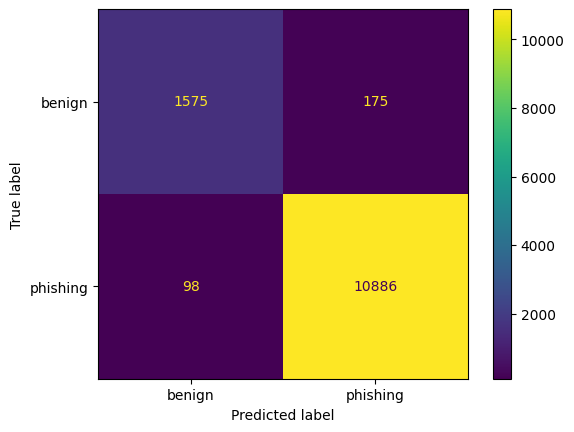

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'phishing'])
disp.plot()
plt.show()

In [ ]:
MODEL_PATH = 'phishing_html_lr.joblib'
joblib.dump(pipeline, MODEL_PATH)
print(f'Model saved to {MODEL_PATH}')

Model saved to phishing_html_lr.joblib


## Next Steps
* **Combine hand‑crafted numeric features** with TF‑IDF using `ColumnTransformer` or `FeatureUnion`.
* **Try alternative models** such as Gradient Boosting, Random Forest, or transformers fine‑tuned on HTML/Text.
* **Add more advanced structural features** (e.g., tag ratio entropy, max DOM depth, embedded media counts).
* **Cross‑validation & hyper‑parameter tuning** with `GridSearchCV` or `Optuna`.
* Evaluate model robustness on unseen, live‑captured web pages.
* Implement a **Chrome Extension** that sends page HTML to the trained model for real‑time detection.